In [11]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g., pd.read_csv)
import sklearn as skl
import matplotlib.pyplot as plt
import seaborn as sns

from pandas import DataFrame
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, classification_report, ConfusionMatrixDisplay
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from scipy.stats import uniform, randint

SEED = 2023

In [12]:
%run "datasets/parse.ipynb"
train_df = parse_train("")
test_df = parse_test("")

In [13]:
categorical_to_numerical = {
    'Injecao na rede (kWh)': {
        'None': 0,
        'Low': 1,
        'Medium': 2,
        'High':3,
        'Very High':4
    },
    'weather_description': {
        'overcast clouds': 0,
        'scattered clouds': 1,
        'few clouds': 2,
        'sky is clear': 3,
        'broken clouds': 4,
        'light rain': 5,
        'moderate rain': 6,
        'heavy intensity rain':7
    }
}

numeric_columns = ['Hora', 'Normal (kWh)', 'Horario Economico (kWh)', 'Autoconsumo (kWh)', 'temp','feels_like','temp_min','temp_max','pressure','humidity', 'wind_speed','clouds_all','rain_1h']


In [14]:
def random_forest_data_preparation(df: DataFrame,test_or_train) -> DataFrame:

    prep_df= df
    prep_df['rain_1h'] = prep_df['rain_1h'].replace('', '0')
    prep_df['rain_1h'] = pd.to_numeric(prep_df['rain_1h'])
            
    ### Converter as features categoricas em numericas
    prep_df.replace(categorical_to_numerical, inplace=True)

    ### Extrair a hora e dia da semana da feature 'record_date'
    record_date = pd.DatetimeIndex(prep_df['Data'])

    prep_df['Month'] = record_date.month
    prep_df['Day'] = record_date.day
    prep_df['Year'] = record_date.year

    dropped_columns = ['grnd_level','sea_level','dt','Data','city_name']
    prep_df = prep_df.drop(dropped_columns, axis=1)

    prep_df.loc[(prep_df['Hora'] < 6) & (prep_df['Hora'] > 21), 'Injecao na rede (kWh)'] = 0

    

   
    ### Limites superior e inferior (sem outliers) dos diagramas de caixa
    whiskers = []
    for num in numeric_columns:
        Q1 = prep_df[num].quantile(0.25)
        Q3 = prep_df[num].quantile(0.75)
        IQR = Q3 - Q1

        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR
        whiskers.append((num,lower,upper))

    ### Tratar os outliers das features numéricas:
    ### Substituir os valores dos outliers pela mediana
    if(test_or_train == "train"):
        for num, lower, upper in whiskers:
            prep_df = prep_df[(prep_df[num] >= lower) & (prep_df[num] <= upper)]

    return prep_df

In [15]:
prep_df = random_forest_data_preparation(train_df,"train")

X = prep_df

# Separate the target variable from the input features
y = X['Injecao na rede (kWh)']
X.drop(columns=['Injecao na rede (kWh)'], inplace=True)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [16]:
params = {
    "max_depth": randint(2, 50), # default 3
    "n_estimators": randint(100, 1000), # default 100
    "min_samples_split":randint(2,10),
    "min_samples_leaf":randint(2,10)
}
kf = KFold(n_splits=5,shuffle=True,random_state=SEED)

model= RandomForestClassifier(random_state=13122001,n_estimators=200,max_depth=100)

search = RandomizedSearchCV(model, param_distributions=params, random_state=42, cv=3, verbose=2, n_jobs=1, return_train_score=True)

search.fit(X_train,np.ravel(y_train))

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END max_depth=40, min_samples_leaf=5, min_samples_split=6, n_estimators=370; total time=   3.7s
[CV] END max_depth=40, min_samples_leaf=5, min_samples_split=6, n_estimators=370; total time=   4.3s
[CV] END max_depth=40, min_samples_leaf=5, min_samples_split=6, n_estimators=370; total time=   3.4s
[CV] END max_depth=44, min_samples_leaf=9, min_samples_split=6, n_estimators=120; total time=   0.9s
[CV] END max_depth=44, min_samples_leaf=9, min_samples_split=6, n_estimators=120; total time=   0.8s
[CV] END max_depth=44, min_samples_leaf=9, min_samples_split=6, n_estimators=120; total time=   0.9s
[CV] END max_depth=40, min_samples_leaf=3, min_samples_split=4, n_estimators=314; total time=   3.1s
[CV] END max_depth=40, min_samples_leaf=3, min_samples_split=4, n_estimators=314; total time=   3.0s
[CV] END max_depth=40, min_samples_leaf=3, min_samples_split=4, n_estimators=314; total time=   3.0s
[CV] END max_depth=12, min_sam

RandomizedSearchCV(cv=3,
                   estimator=RandomForestClassifier(max_depth=100,
                                                    n_estimators=200,
                                                    random_state=13122001),
                   n_jobs=1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000110F839A0B0>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000110FCEBC0A0>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000110F839B100>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x00000110F839B940>},
                   random_state=42, return_train_score=True, verbose=2)

In [17]:
search.best_estimator_

RandomForestClassifier(max_depth=22, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=413, random_state=13122001)

In [18]:
predictions = search.best_estimator_.predict(X_test)
print(classification_report(y_test, predictions))
print('Accuracy:', metrics.accuracy_score(y_test, predictions))
print('F1_score (micro):', f1_score(y_test, predictions, average='micro'))
print('Recall (micro):', recall_score(y_test, predictions, average='micro'))
#print(plot_confusion_matrix(search.best_estimator_,X_test,y_test))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1022
           1       0.35      0.14      0.20        51
           2       0.53      0.69      0.60       124
           3       0.68      0.71      0.69       164
           4       0.81      0.63      0.71        73

    accuracy                           0.87      1434
   macro avg       0.67      0.63      0.63      1434
weighted avg       0.87      0.87      0.87      1434

Accuracy: 0.8723849372384938
F1_score (micro): 0.8723849372384938
Recall (micro): 0.8723849372384938


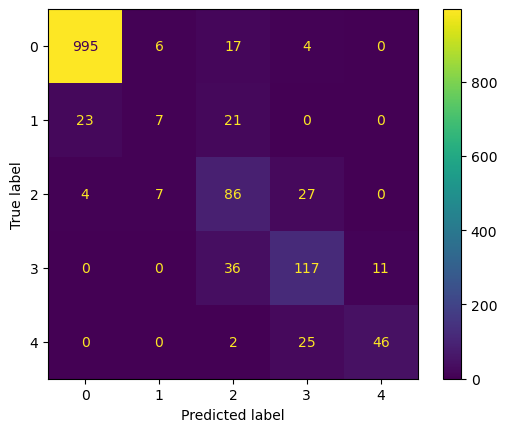

In [19]:
cm = confusion_matrix(y_test, predictions)
# TP FP
# FN TN
disp = ConfusionMatrixDisplay(cm)

disp.plot()

In [20]:
predict = random_forest_data_preparation(test_df,"test").drop('Injecao na rede (kWh)',axis=1)

predictions = search.best_estimator_.predict(predict)

predictions_df = pd.DataFrame(predictions)

numerical_to_categorical = {
    0: {
        0 : 'None',
        1 : 'Low',
        2 : 'Medium',
        3 : 'High',
        4 : 'Very High'
    }
}

predictions_df.replace(numerical_to_categorical, inplace=True)

predictions_df.index += 1

predictions_df.to_csv("submission.csv", header=['Result'], index_label='RowId')